# Gradient descent optimiser

For problems where the gradient of the objective is known, we can use a simple [gradient descent]() algorithm.
Starting from any point $x[i]$, this optimiser takes the step:

$$ x[i + 1] = x[i] - \eta \cdot \nabla f(x[i]) $$

where $\eta$ is a fixed parameter called the learning rate, and $\nabla f(x[i])$ is the gradient of the objective function.

## Example 1: finding the bottom of a parabolic valley

We start off by defining a simple error function: a parabola centered at the origin:

In [1]:
import pints
import pints.toy

# Create a parabolic error function
error = pints.toy.ParabolicError()

To see what this function looks like, we'll use a contour plot.

This will get re-used later in the example, so we define a function to create it:

In [2]:
import matplotlib.pyplot as plt
import numpy as np

# Evaluate the error function on a grid of points
X = np.arange(-2, 2.1, 0.1)
Y = np.arange(-1, 1.1, 0.1)
Z = np.zeros((len(Y), len(X)))
for i, x in enumerate(X):
    for j, y in enumerate(Y):
        Z[j, i] = error((x, y))
X, Y = np.meshgrid(X, Y)

# Define a function to create a contour plot
def create_contour_plot():

    # Create figure
    fig = plt.figure(figsize=(16, 8))
    ax = plt.subplot(1, 1, 1)
    plt.xlim(-2, 2)
    plt.ylim(-1, 1)

    # Plot the contours
    plt.contour(X, Y, Z, levels=20)
    
    # Show where the optimum is
    plt.plot([0], [0], 'x', color='red', label='optimum', markersize=20)

Next, we'll choose a starting point for our optimisation, and plot it on the contours of the error function:

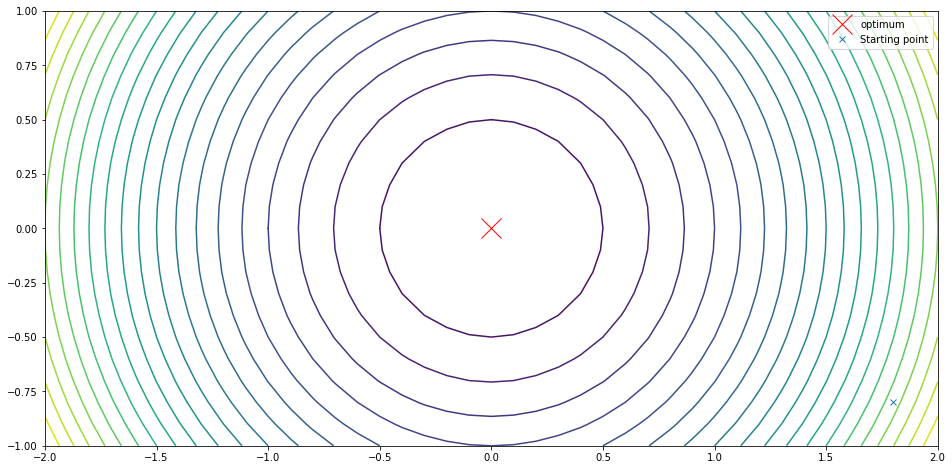

In [3]:
# Create a contour plot
create_contour_plot()

# Choose a starting point for the optimisation
x0 = [1.8, -0.8]

# Show the starting point
plt.plot(x0[0], x0[1], 'x', label='Starting point')

# Show the whole figure
plt.legend()
plt.show()

Now that the problem is all set up, we create a gradient descent optimiser and use the ask-and-tell interface to let it walk a few steps.

We can use the ``sigma0`` property to set the learning rate $\eta = 0.1$.

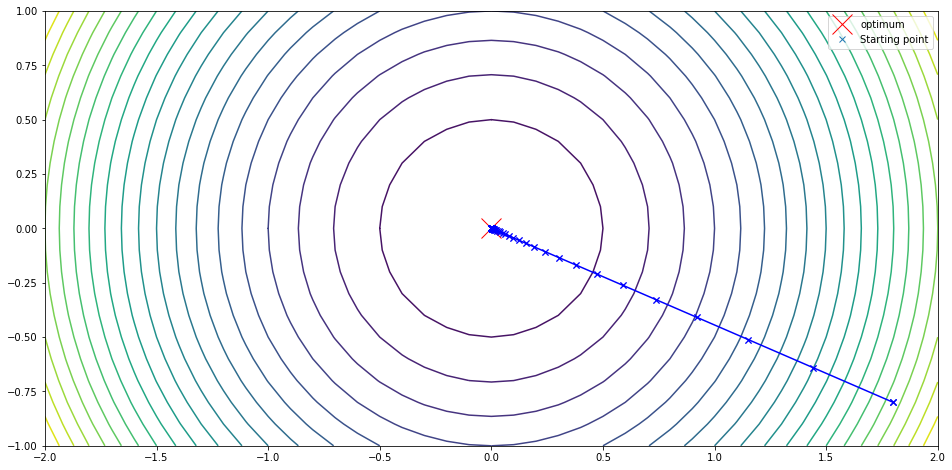

In [4]:
# Create a nice plot
create_contour_plot()
plt.plot(x0[0], x0[1], 'x', label='Starting point')

# Create an gradient descent optimiser with a learning rate of 0.1
opt = pints.GradientDescent(x0, sigma0=0.1)

# Create an evaluator to evaluate the error function
# Because this method requires gradients, we must pass in the EvaluateS1 function
e = pints.SequentialEvaluator(error.evaluateS1)

# Walk a few steps, and plot the results
x1 = x0
for i in range(50):
    xs = opt.ask()
    fs = e.evaluate(xs)
    opt.tell(fs)
    
    x2 = xs[0]
    plt.plot((x1[0], x2[0]), (x1[1], x2[1]), 'x-', color='blue')
    x1 = x2

# Show the whole figure
plt.legend()
plt.show()

Because the gradient is very simple in this example, the optimiser can walk straight to the optimum.

At the same time, because the function gets flatter towards the optimum, the optimiser slows down and only converges very slowly to the true point.

## Example 2: Maximising a difficult LogPDF

We can also try this method on a much more difficult problem, the ["banana" twisted gaussian LogPDF](https://pints.readthedocs.io/en/latest/toy/twisted_gaussian_logpdf.html).

In the formulation included in PINTS, this is implemented as a probability density function, a LogPDF, and so we need to maximise it instead of minimising it.
An easy way to do this is to wrap a [ProbabilityBasedError](https://pints.readthedocs.io/en/latest/error_measures.html#pints.ProbabilityBasedError) around the LogPDF, turning it into an error we can minimise just like before.

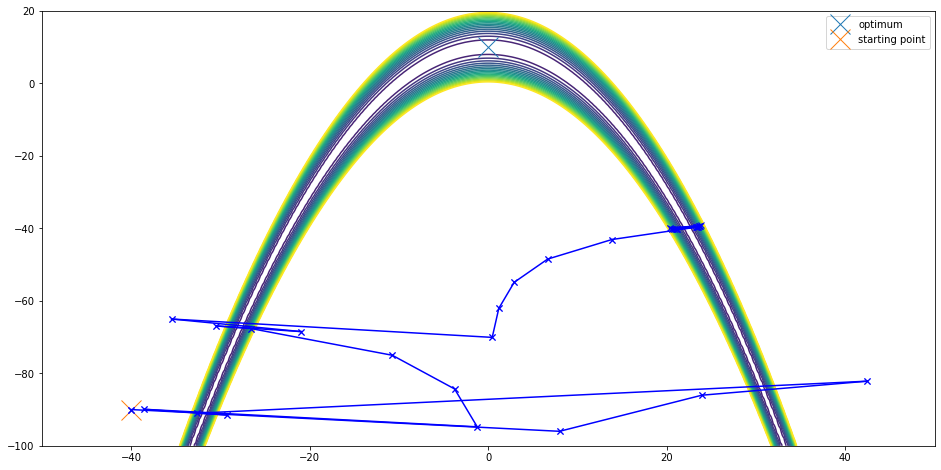

In [5]:
# Define a LogPDF (a 2-dimensional twisted gaussian)
logpdf = pints.toy.TwistedGaussianLogPDF(dimension=2)

# Wrap an error around the LogPDF
error = pints.ProbabilityBasedError(logpdf)

# Create figure
fig = plt.figure(figsize=(16, 8))
ax = plt.subplot(1, 1, 1)
plt.xlim(-50, 50)
plt.ylim(-100, 20)

# Evaluate the error function on a grid of points
levels = np.linspace(1, 50, 20)
x = np.linspace(-50, 50, 250)
y = np.linspace(-100, 20, 250)
X, Y = np.meshgrid(x, y)
Z = [[error([i, j]) for i in x] for j in y]
plt.contour(X, Y, Z, levels=levels)

# Show the optimum
plt.plot(0, 10, 'x', markersize=20, label='optimum')

# Pick a starting point
x0 = [-40, -90]
plt.plot(x0[0], x0[1], 'x', markersize=20, label='starting point')

# Create an optimiser
opt = pints.GradientDescent(x0, sigma0=0.1)

# Create an evaluator to evaluate the error function
# Because this method requires gradients, we must pass in the EvaluateS1 function
e = pints.SequentialEvaluator(error.evaluateS1)

# Walk a few steps, and plot the results
x1 = x0
for i in range(30):
    xs = opt.ask()
    fs = e.evaluate(xs)
    opt.tell(fs)
    
    x2 = xs[0]
    plt.plot((x1[0], x2[0]), (x1[1], x2[1]), 'x-', color='blue')
    x1 = x2

# Show the whole figure
plt.legend()
plt.show()

We can see the method getting into some real trouble here!

Initially, the steep gradient causes it to make large jumps and massively overshoot its target, causing the erratic behaviour in the first part of the problem.
Eventually, the method gets lucky and manages to land near a high probability area (center right).
However, at this point the gradient is still so steep that the method keeps overshooting the narrow band, and bounces from left to right.

At this point, we might try reducing the step size by lowering the "learning rate" parameter:

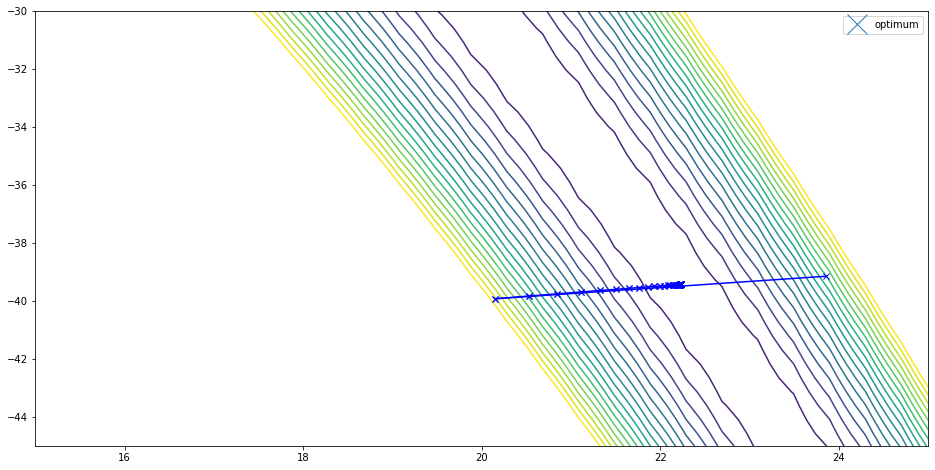

In [6]:
# Create figure
fig = plt.figure(figsize=(16, 8))
ax = plt.subplot(1, 1, 1)
plt.xlim(15, 25)
plt.ylim(-45, -30)
plt.contour(X, Y, Z, levels=levels)
plt.plot(0, 10, 'x', markersize=20, label='optimum')

# Reduce the learning rate
opt.set_learning_rate(0.01)

# Walk some more steps, and plot the results
for i in range(250):
    xs = opt.ask()
    fs = e.evaluate(xs)
    opt.tell(fs)
    
    x2 = xs[0]
    plt.plot((x1[0], x2[0]), (x1[1], x2[1]), 'x-', color='blue')
    x1 = x2

# Show the whole figure
plt.legend()
plt.show()

This problem is really hard! The method is still mostly moving up and down the steep gradient, instead of flowing along "the band" towards the true optimum.

It seems some other method might be needed to tackle this type of problem.

## Example 3: A noisy time-series problem

Finally, we can try applying this method to a noisy time series problem:

In [7]:
# Load a forward model
model = pints.toy.LogisticModel()

# Create some toy data
real_parameters = [0.015, 500]
times = np.linspace(0, 1000, 1000)
values = model.simulate(real_parameters, times)

# Add noise
values += np.random.normal(0, 10, values.shape)

# Create an object with links to the model and time series
problem = pints.SingleOutputProblem(model, times, values)

# Select a score function
score = pints.SumOfSquaresError(problem)

# Perform an optimization
x0 = [0.01, 450]
opt = pints.OptimisationController(
    score,
    x0,
    method=pints.GradientDescent
)
found_parameters, found_value = opt.run()

# Show score of true solution
print('Score at true solution: ')
print(score(real_parameters))

# Compare parameters with original
print('Found solution:          True parameters:' )
for k, x in enumerate(found_parameters):
    print(pints.strfloat(x) + '    ' + pints.strfloat(real_parameters[k]))

Minimising error measure
Using Gradient descent
Running in sequential mode.
Iter. Eval. Best      Current   Time m:s
0     1      1.92e+07  1.92e+07   0:00.0
1     2      1.92e+07  1.92e+07   0:00.0
2     3      1.92e+07  1.92e+07   0:00.0
3     4      1.92e+07  1.92e+07   0:00.0
20    21     1.92e+07  1.92e+07   0:00.0
40    41     1.92e+07  1.92e+07   0:00.0
60    61     1.92e+07  1.92e+07   0:00.0
80    81     1.92e+07  1.92e+07   0:00.0
100   101    1.92e+07  1.92e+07   0:00.0
120   121    1.92e+07  1.92e+07   0:00.0
140   141    1.92e+07  1.92e+07   0:00.0
160   161    1.92e+07  1.92e+07   0:00.0
180   181    1.92e+07  1.92e+07   0:00.0
200   201    1.92e+07  1.92e+07   0:00.0
201   201    1.92e+07  1.92e+07   0:00.0
Halting: No significant change for 200 iterations.
Score at true solution: 
109351.17380755962
Found solution:          True parameters:
 1.00000000000000002e-02     1.49999999999999994e-02
 4.50000000000000000e+02     5.00000000000000000e+02


The problem here is that the optimiser changes both parameters at once, and by similar amounts.
But if we look at the parameters, we can see they have very different magnitudes!
As a result, there is no single step-size that works for both parameters.
More complicated methods exist that deal with this problem automatically, but we can also solve it ourselves by rescaling the parameters:

In [8]:
class RescaledModel(pints.ForwardModel):
    def __init__(self):
        self.base_model = pints.toy.LogisticModel()
    
    def simulate(self, parameters, times):
        # Run a simulation with the given parameters for the
        # given times and return the simulated values
        r, k = parameters
        r = r / 50
        k = k * 500
        return self.base_model.simulate([r, k], times)
    
    def simulateS1(self, parameters, times):
        # Run a simulation with the given parameters for the
        # given times and return the simulated values
        r, k = parameters
        r = r / 50
        k = k * 500
        return self.base_model.simulateS1([r, k], times)
    
    def n_parameters(self):
        # Return the dimension of the parameter vector
        return 2

model = RescaledModel()

# Create an object with links to the model and time series
problem = pints.SingleOutputProblem(model, times, values)

# Select a score function
score = pints.SumOfSquaresError(problem)

# Perform an optimization
x0 = [1, 1]
opt = pints.OptimisationController(
    score,
    x0,
    method=pints.GradientDescent
)

opt.optimiser().set_learning_rate(1e-10)
opt.set_max_iterations(100)

found_parameters, found_value = opt.run()

# Rescale parameters
found_parameters = list(found_parameters)
found_parameters[0] = found_parameters[0] / 50
found_parameters[1] = found_parameters[1] * 500

# Show score of true solution
print('Score at true solution: ')
print(score(real_parameters))

# Compare parameters with original
print('Found solution:          True parameters:' )
for k, x in enumerate(found_parameters):
    print(pints.strfloat(x) + '    ' + pints.strfloat(real_parameters[k]))

Minimising error measure
Using Gradient descent
Running in sequential mode.
Iter. Eval. Best      Current   Time m:s
0     1      6122209   6122209    0:00.0
1     2      703542.4  703542.4   0:00.0
2     3      165048.3  165048.3   0:00.0
3     4      131640.3  131640.3   0:00.0
20    21     109343.5  109343.5   0:00.0
40    41     109343    109343     0:00.0
60    61     109342.4  109342.4   0:00.0
80    81     109341.8  109341.8   0:00.0
100   100    109341.3  109341.3   0:00.0
Halting: Maximum number of iterations (100) reached.
Score at true solution: 
139528612.7640636
Found solution:          True parameters:
 1.49966855162342889e-02     1.49999999999999994e-02
 4.99992932482746994e+02     5.00000000000000000e+02


Much better!